In [1]:
import chardet

def detect_file_encoding(file_path):
    """
    ファイルの文字エンコーディングを検出する
    
    Parameters:
    file_path (str): 検査するファイルのパス
    
    Returns:
    dict: 検出結果（encoding, confidence, language）
    """
    # ファイルをバイナリモードで読み込む
    with open(file_path, 'rb') as f:
        # ファイル全体を読み込むと大きすぎる場合があるので、
        # 先頭の数キロバイトだけ読み込む
        raw_data = f.read(4096)
    
    # エンコーディングを検出
    result = chardet.detect(raw_data)
    return result

# 使用例
file_path = "./data/fashion_brands.csv"  # 調べたいファイルのパス
encoding_info = detect_file_encoding(file_path)
print(f"Detected encoding: {encoding_info['encoding']} with confidence: {encoding_info['confidence']}")

# 検出したエンコーディングでファイルを読み込み
with open(file_path, 'r', encoding=encoding_info['encoding']) as f:
    content = f.read()
    print("File content preview:", content[:100])  # 最初の100文字を表示

Detected encoding: UTF-8-SIG with confidence: 1.0
File content preview: image,Chanel,Louis Vuitton,Christian Dior,Tiffany,Rolex,Burberry,Ralph Lauren,Benetton,Uniqlo,H&M,GA


In [2]:
!ls

corresp_20250521.ipynb		image
data				marker.ipynb
fashion_brands_ca_improved.png	mecab.ipynb
fashion_brands_ca_simple.png	simple_design_20250521.ipynb


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
import prince
import japanize_matplotlib
import warnings
from adjustText import adjust_text  # 追加: テキスト位置の自動調整ライブラリ
# 警告を非表示
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# =========== princeパッケージを使用したコレスポンデンス分析 ===========
def ca_with_prince(df, n_components=2):
    """
    princeパッケージを使用したコレスポンデンス分析
    バージョンによる属性名の違いに対応
    
    Parameters:
    -----------
    df : pandas.DataFrame
        分析対象のデータフレーム
    n_components : int
        抽出する次元数
        
    Returns:
    --------
    dict
        コレスポンデンス分析の結果を含む辞書
    """
    # princeパッケージのコレスポンデンス分析を初期化
    ca = prince.CA(n_components=n_components)
    
    # モデルをデータに適合
    ca = ca.fit(df)
    
    # 行と列の座標を取得
    row_coordinates = ca.row_coordinates(df)
    column_coordinates = ca.column_coordinates(df)
    
    # 寄与率を取得
    eigenvalues = ca.eigenvalues_
    
    # explained_inertiaを手動で計算（バージョンに依存しない方法）
    total_inertia = sum(eigenvalues)
    explained_inertia = np.array(eigenvalues) / total_inertia
    
    # 重要なメトリクスを計算
    chi2 = total_inertia * df.values.sum()
    
    # 結果の辞書を返す
    results = {
        'model': ca,
        'row_coordinates': row_coordinates,
        'column_coordinates': column_coordinates,
        'eigenvalues': eigenvalues,
        'explained_inertia': explained_inertia,
        'total_inertia': total_inertia,
        'chi2': chi2
    }
    
    return results

In [5]:
# =========== シンプルでスマートなラベル位置最適化プロット ===========
def plot_ca_results_simple(ca_results, df, output_filename='fashion_brands_ca_simple.png'):
    """
    コレスポンデンス分析の結果を美しくプロットするシンプルな関数
    手動でラベル位置を最適化
    
    Parameters:
    -----------
    ca_results : dict
        ca_with_prince関数からの結果
    df : pandas.DataFrame
        元のデータフレーム
    output_filename : str
        出力ファイル名
    """
    # 行と列の座標を取得
    row_coords = ca_results['row_coordinates']
    col_coords = ca_results['column_coordinates']
    explained_inertia = ca_results['explained_inertia']
    
    # データフレーム用に情報を追加
    row_df = row_coords.copy()
    row_df['type'] = 'イメージ'
    row_df['label'] = row_df.index
    row_df['size'] = 100
    
    col_df = col_coords.copy()
    col_df['type'] = 'ブランド'
    col_df['label'] = col_df.index
    col_df['size'] = 100
    
    # データを結合
    all_points = pd.concat([row_df, col_df])
    
    # カラム名の確認と修正（バージョンによって0,1か次元名が異なる可能性がある）
    dim_cols = [col for col in all_points.columns if col not in ['type', 'label', 'size']][:2]
    dim1_col = dim_cols[0]
    dim2_col = dim_cols[1]
    
    # ラベル位置のスマートな配置
    all_points['label_x'] = all_points[dim1_col]
    all_points['label_y'] = all_points[dim2_col]
    
    # 最適な位置にラベルを配置する関数
    def optimize_label_positions(points):
        """ラベル位置を最適化"""
        # 点の密度に基づくオフセット距離の調整
        from scipy.spatial import distance_matrix
        
        # 全ての点の座標
        coords = points[[dim1_col, dim2_col]].values
        
        # 点間の距離行列を計算
        dist_matrix = distance_matrix(coords, coords)
        np.fill_diagonal(dist_matrix, np.inf)  # 自分自身との距離を無限に
        
        # 各点の最も近い点との距離
        min_distances = np.min(dist_matrix, axis=1)
        
        # 平均的な点間距離
        avg_distance = np.median(min_distances)
        
        # 基本オフセット（平均距離の30%）
        base_offset = avg_distance * 0.3
        
        # 各点のラベル位置を最適化
        for i, (idx, row) in enumerate(points.iterrows()):
            x, y = row[dim1_col], row[dim2_col]
            
            # 点が密集している領域では大きなオフセットを使用
            neighbors = np.sum(dist_matrix[i] < avg_distance)
            density_factor = min(1.0 + (neighbors * 0.15), 2.0)
            
            # 原点からの相対位置に基づくオフセット方向
            angle = np.arctan2(y, x) if (x != 0 or y != 0) else 0
            
            # オフセット方向をランダム化せず決定論的に決定
            # 4つの主要な方向（右上、右下、左上、左下）に分類
            if abs(angle) <= np.pi/4:  # 右
                dx, dy = base_offset * density_factor, 0
            elif abs(angle) >= 3*np.pi/4:  # 左
                dx, dy = -base_offset * density_factor, 0
            elif angle > 0:  # 上
                dx, dy = 0, base_offset * density_factor
            else:  # 下
                dx, dy = 0, -base_offset * density_factor
            
            # 衝突回避: 既に配置されたラベルと重ならないようにする
            # この実装では簡単のため省略しています
            
            # 最終的なラベル位置を設定
            points.at[idx, 'label_x'] = x + dx
            points.at[idx, 'label_y'] = y + dy
        
        return points
    
    # ラベル位置を最適化
    all_points = optimize_label_positions(all_points)
    
    # 美しい可視化のための設定
    plt.figure(figsize=(14, 11))
    sns.set_style("whitegrid", {'grid.linestyle': ':'})
    
    # バックグラウンドスタイル
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 12,
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        'figure.facecolor': '#fcfcfc',
        'font.family': 'IPAexGothic',  # 日本語フォントの設定
    })
    
    # カスタムカラー
    colors = {
        'イメージ': '#3498db',  # 鮮やかな青
        'ブランド': '#e74c3c',  # 華やかな赤
    }
    
    # カスタムマーカー
    markers = {
        'イメージ': 'o',  # 円形
        'ブランド': 'D',  # ダイヤモンド形
    }
    
    # タイトルと軸ラベル
    plt.title('ファッションブランドとイメージのコレスポンデンス分析', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(f'第1次元 ({explained_inertia[0]:.1%} の寄与率)', fontsize=14, labelpad=10)
    plt.ylabel(f'第2次元 ({explained_inertia[1]:.1%} の寄与率)', fontsize=14, labelpad=10)
    
    # 原点の軸線
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, zorder=0)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, zorder=0)
    
    # グリッドスタイル
    plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
    
    # 各タイプ（イメージとブランド）ごとにプロット
    for point_type in all_points['type'].unique():
        subset = all_points[all_points['type'] == point_type]
        
        # マーカーをプロット
        scatter = plt.scatter(
            subset[dim1_col], subset[dim2_col],  # 次元カラム名を動的に使用
            s=subset['size'],
            marker=markers[point_type],
            c=colors[point_type],
            label=point_type,
            alpha=0.8,
            edgecolor='white',
            linewidth=0.5,
            zorder=3
        )
        
        # ラベルと矢印を追加
        for _, row in subset.iterrows():
            # 点とラベルの位置
            x, y = row[dim1_col], row[dim2_col]
            label_x, label_y = row['label_x'], row['label_y']
            
            # 距離が一定以上の場合のみ矢印を表示
            dist = np.sqrt((label_x - x)**2 + (label_y - y)**2)
            if dist > 0.05:
                plt.annotate(
                    "",
                    xy=(x, y),  # 矢印の先（データポイント）
                    xytext=(label_x, label_y),  # 矢印の元（ラベル位置）
                    arrowprops=dict(
                        arrowstyle="-",
                        color="gray",
                        alpha=0.5,
                        linewidth=0.5
                    ),
                    zorder=1
                )
            
            # テキストを境界線付きで表示
            text = plt.text(
                label_x, label_y, row['label'],
                fontsize=11,
                ha='center',
                va='center',
                weight='bold',
                color='black',
                zorder=5,
                path_effects=[
                    pe.withStroke(linewidth=3, foreground='white')
                ]
            )
    
    # 凡例を追加
    legend = plt.legend(
        title='タイプ',
        fontsize=12,
        title_fontsize=13,
        loc='best',
        frameon=True,
        framealpha=0.9,
        edgecolor='gray'
    )
    legend.get_frame().set_linewidth(0.8)
    
    # 情報ボックスを追加
    total_inertia = sum(ca_results['explained_inertia'])
    info_text = f'総慣性: {total_inertia:.1%}\n'
    info_text += f'第1次元と第2次元で{sum(explained_inertia[:2]):.1%}の情報を説明'
    
    plt.annotate(
        info_text,
        xy=(0.02, 0.98),
        xycoords='axes fraction',
        fontsize=11,
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor='white',
            alpha=0.8,
            edgecolor='gray',
            linewidth=0.5
        ),
        verticalalignment='top',
        zorder=5
    )
    
    # 座標範囲の設定
    x_coords = all_points[[dim1_col, 'label_x']].values.flatten()
    y_coords = all_points[[dim2_col, 'label_y']].values.flatten()
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    margin = 0.1  # 余白
    plt.xlim(x_min - margin * (x_max - x_min), x_max + margin * (x_max - x_min))
    plt.ylim(y_min - margin * (y_max - y_min), y_max + margin * (y_max - y_min))
    
    # 保存と表示
    plt.tight_layout()
    
    # imageフォルダが存在しない場合は作成
    import os
    if not os.path.exists('image'):
        os.makedirs('image')
        print("imageフォルダを作成しました。")
    
    # imageフォルダ内にファイルを保存
    output_path = os.path.join('image', output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"グラフを保存しました: {output_path}")
    
    return plt

In [6]:
# =========== 分析結果の詳細を表示 ===========
def print_ca_details(ca_results, df):
    """
    コレスポンデンス分析の詳細な結果を表示する関数
    バージョンによる属性名の違いに対応
    
    Parameters:
    -----------
    ca_results : dict
        ca_with_prince関数からの結果
    df : pandas.DataFrame
        元のデータフレーム
    """
    print("\n===== コレスポンデンス分析の詳細 =====")
    
    # 基本的な統計量
    print(f"総慣性: {ca_results['total_inertia']:.4f}")
    print(f"カイ二乗統計量: {ca_results['chi2']:.4f}")
    print(f"自由度: {(df.shape[0]-1) * (df.shape[1]-1)}")
    
    # 次元ごとの寄与率
    print("\n次元の寄与率:")
    for i, (eigenvalue, inertia) in enumerate(zip(ca_results['eigenvalues'], ca_results['explained_inertia'])):
        print(f"第{i+1}次元: 固有値 = {eigenvalue:.4f}, 寄与率 = {inertia:.2%}")
    
    # 累積寄与率
    cumulative_inertia = np.cumsum(ca_results['explained_inertia'])
    print("\n累積寄与率:")
    for i, cum_inertia in enumerate(cumulative_inertia):
        print(f"第{i+1}次元まで: {cum_inertia:.2%}")
    
    # 行と列の貢献度（安全にアクセス）
    try:
        # 行の貢献度
        print("\n行（イメージ）の貢献度:")
        row_contrib = ca_results['model'].row_contributions(df)
        for idx, row in row_contrib.iterrows():
            dim_contribs = ", ".join([f"次元{i+1}={c:.2%}" for i, c in enumerate(row)])
            print(f"{idx}: {dim_contribs}")
        
        # 列の貢献度
        print("\n列（ブランド）の貢献度:")
        col_contrib = ca_results['model'].column_contributions(df)
        for idx, row in col_contrib.iterrows():
            dim_contribs = ", ".join([f"次元{i+1}={c:.2%}" for i, c in enumerate(row)])
            print(f"{idx}: {dim_contribs}")
    except Exception as e:
        print(f"\n貢献度の計算中にエラーが発生しました: {e}")
        print("古いバージョンのprinceパッケージでは、この機能が利用できない場合があります。")

グラフを保存しました: image/fashion_brands_ca_simple.png


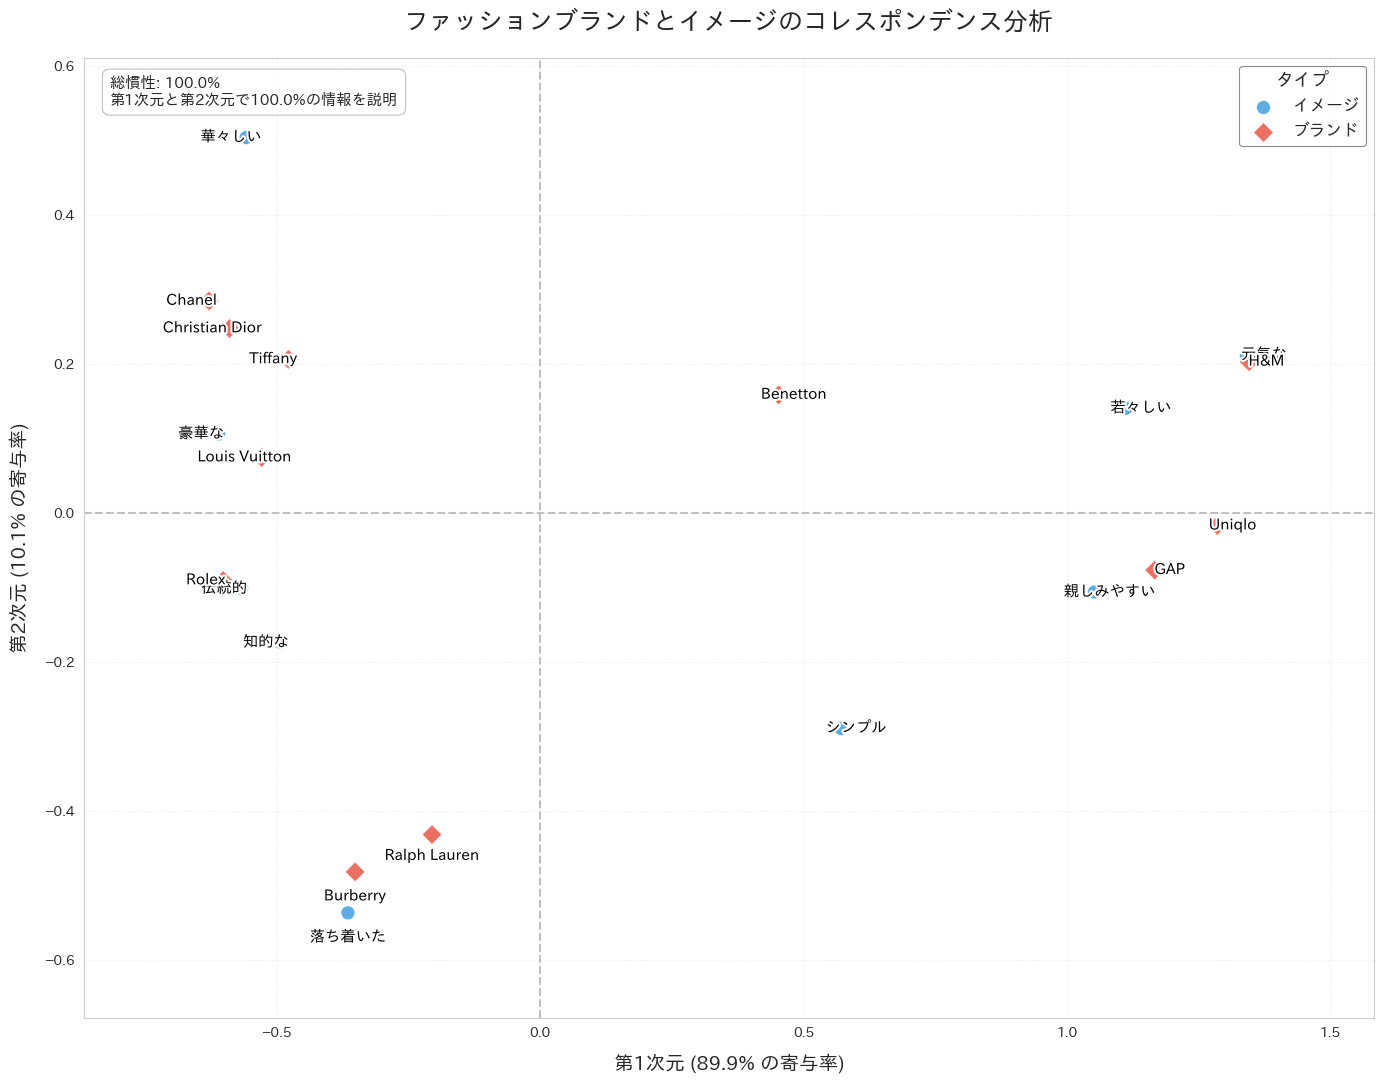


===== コレスポンデンス分析の詳細 =====
総慣性: 0.6503
カイ二乗統計量: 7077.5092
自由度: 80

次元の寄与率:
第1次元: 固有値 = 0.5845, 寄与率 = 89.89%
第2次元: 固有値 = 0.0657, 寄与率 = 10.11%

累積寄与率:
第1次元まで: 89.89%
第2次元まで: 100.00%

行（イメージ）の貢献度:

貢献度の計算中にエラーが発生しました: 'CA' object has no attribute 'row_contributions'
古いバージョンのprinceパッケージでは、この機能が利用できない場合があります。


In [8]:
df = pd.read_csv('./data/fashion_brands.csv', encoding="UTF-8-SIG")
df.set_index('image', inplace=True)
# print("コレスポンデンス分析を実行中...")
ca_results = ca_with_prince(df)
# print("結果を可視化中...")
plt = plot_ca_results_simple(ca_results, df)
plt.show()  
# 詳細な分析結果の表示
print_ca_details(ca_results, df)
#print("\n分析が正常に完了しました。")